In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from skbio.stats.composition import clr, centralize, alr_inv
from skbio.stats.composition import clr_inv as softmax
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

from src.generators import ground_truth_edges
from src.evaluate import _edge_roc_curve
from biom import load_table
from scipy.stats import spearmanr, pearsonr
import glob
#import yaml
%matplotlib inline

# Growth simulation benchmark

In [14]:
results_dir = '../results/benchmark_output/growth_sims'

In [23]:
fnames = [
    ['pearson', 'abs_pearson.txt', 'rel_pearson.txt'],
    ['spearman', 'abs_spearman.txt', 'rel_spearman.txt'],
    ['sparcc', 'cor_matrix_abs_growth_0622_SparCC.csv', 'cor_matrix_rel_growth_0622_SparCC.csv'],
    ['phi', 'prop_matrix_abs_growth_0622_PHI.csv', 'prop_matrix_rel_growth_0622_PHI.csv'],
    ['rho', 'prop_matrix_abs_growth_0622_RHO.csv', 'prop_matrix_rel_growth_0622_RHO.csv'],
    ['spiec-easi', 'weights_abs_growth_0622_SPIECEASI.csv', 'weights_rel_growth_0622_SPIECEASI.csv']
]

In [24]:
pearson_ranks = pd.read_table(os.path.join(
    results_dir, 'rel/rel_pearson.txt'), index_col=0)
microbes, metabolites = pearson_ranks.index, pearson_ranks.columns

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


In [25]:
# actual plotting
def plot_tool(tool, abs_file, rel_file, axs):
    if '.txt' in abs_file or '.txt' in rel_file:
        abs_ranks = pd.read_table(os.path.join(results_dir, 'abs/' + abs_file),
                                  index_col=0).loc[microbes, metabolites]
        rel_ranks = pd.read_table(os.path.join(results_dir, 'rel/' + rel_file),
                                  index_col=0).loc[microbes, metabolites]
    else:
        abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/' + abs_file),
                                index_col=0).loc[microbes, metabolites]
        rel_ranks = pd.read_csv(os.path.join(results_dir, 'rel/' + rel_file),
                                index_col=0).loc[microbes, metabolites]        
        
    for i in range(abs_ranks.shape[0]):
        axs.scatter(abs_ranks.values[i, 2:], rel_ranks.values[i, 2:], linewidth=1,
                    facecolors='none', edgecolors='k', alpha=0.5)
    metabolite_cmap = plt.cm.PiYG

    #r = '#E34234'
    #g = '#0D98BA'
    r = [0.55686275, 0.00392157, 0.32156863, 1.]
    g = [0.15294118, 0.39215686, 0.09803922, 1.]
    print(r, g)
    # negative metabolite
    for i in range(1, abs_ranks.shape[0]):
        axs.scatter(abs_ranks.values[i, 1], rel_ranks.values[i, 1], marker='v', linewidth=1,
                    s=50,
                    facecolors=r, edgecolors='w')
    axs.scatter(abs_ranks.values[1, 1], rel_ranks.values[1, 1], marker='v', linewidth=1,
                s=50,
                facecolors=r, edgecolors='w', label='- metabolite, - microbe')    
    axs.scatter(abs_ranks.values[0, 1], rel_ranks.values[0, 1], marker='v', linewidth=1,
                s=50,
                facecolors=r, edgecolors='w', label='- metabolite, + microbe')
    
    # positive metabolite
    for i in range(1, abs_ranks.shape[0]):
        axs.scatter(abs_ranks.values[i, 0], rel_ranks.values[i, 0], marker='^', linewidth=1,
                    s=50,
                    facecolors=g, edgecolors='w')
    axs.scatter(abs_ranks.values[1, 0], rel_ranks.values[1, 0], marker='^', linewidth=1,
                s=50,
                facecolors=g, edgecolors='w', label='+ metabolite, - microbe')    
    axs.scatter(abs_ranks.values[0, 0], rel_ranks.values[0, 0], marker='^', linewidth=1,
                s=50,
                facecolors=g, edgecolors='w', label='+ metabolite, + microbe')  
    axs.tick_params(axis="x", labelsize=14)
    axs.tick_params(axis="y", labelsize=14)
    axs.xaxis.set_major_locator(plt.MaxNLocator(4))
    axs.yaxis.set_major_locator(plt.MaxNLocator(4))    
    axs.set_title(tool, fontsize=18)
    axs.set_xlabel('Absolute', fontsize=14)
    axs.set_ylabel('Relative', fontsize=14)

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]
[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]
[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]
[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]
[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]
[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]


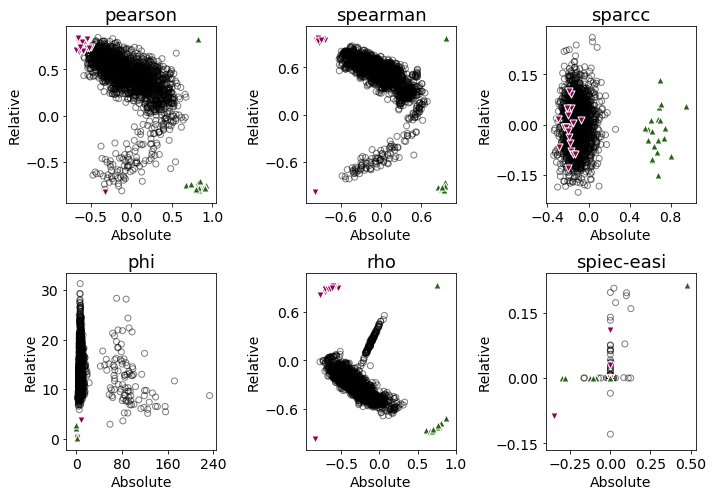

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
for idx, res in enumerate(fnames):
    t, a, r = res
    i, j = idx // 3, idx % 3
    plot_tool(t, a, r, ax[i][j])
    
plt.tight_layout()    

/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """
/Users/jmorton/miniconda3/envs/mmvec/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  import sys


[0.55686275, 0.00392157, 0.32156863, 1.0] [0.15294118, 0.39215686, 0.09803922, 1.0]


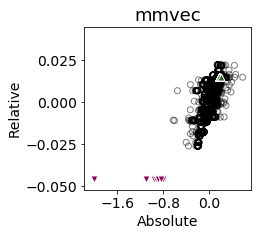

In [27]:
fig, ax = plt.subplots(1, figsize=(3, 3))
t, a, r = 'mmvec', 'abs_mmvec.txt', 'rel_mmvec.txt'
plot_tool(t, a, r, ax)